In [229]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial


from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt# Switch off the cache 
from sklearn.metrics import confusion_matrix 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [234]:
class MultilayerPerceptron():
    def __init__(self,layers,lr,labels,k_clases,samples,x,y,y_hot,stop,max_steps):
        ''' 
        layers=[input,hidden,...,hidden,output]
        lr=learning rate
        epochs
        labels= [0,1,2,3,...k]
        k_clases=k
        samples=n

        '''
        self.sizes=layers #[input, hidden, hidden,....,output]
        self.lr=lr
        self.labels=labels
        self.k_clases=k_clases
        self.samples=samples
        self.x=x
        self.y=y
        self.y_hot=y_hot
        self.stop=stop #stopping criteria
        self.max_steps=max_steps #maximum number of steps
        
        self.weights=self.init_network_params(self.sizes, random.PRNGKey(0) )


    #tenemos la matriz de pesos. Como tenemos la capa de input y una hidden, por eso tenemos dos pessos y dos bias    
    @staticmethod
    def random_layer_params(m, n, key, scale=1):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,1))

        # Initialize all layers for a fully-connected neural network with sizes "sizes"
    def init_network_params(self,sizes, key):
        keys = random.split(key, len(sizes))
        return [self.random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    #@staticmethod
    def one_hot(y, k_clases):
        """Create a one-hot encoding of y of size k_clases."""
        return jnp.array(y[:, None] == jnp.arange(k_clases))
    @staticmethod
    def activacion(x):
        return jnp.tanh(x)#jnp.maximum(0, x)#
    @staticmethod
    def softmax(Z):
        A = jnp.exp(Z) / jnp.sum(jnp.exp(Z),axis=0)
        return A

    def forward(self,weights,x):
        #input to hidden layers
        activations=x
        for w,b in weights[:-1]:
            outputs=jnp.dot(w,activations) + b #size -> (hidden,hidden anterior)
            activations=self.activacion(outputs)
            
        #last hidden to output
        #we use softmax for the last one
        w_last, b_last = weights[-1]
        #print(w_last)
        logits = jnp.dot(w_last, activations) + b_last
        #print('logits',logits)
        soft=self.softmax(logits) #size -> (classes,samples) ****
        return soft
    
    def loss_function(self,weights,x,y_hot):

        soft=self.forward(weights,x)
        #print('soft',soft)
        #loss=jnp.mean(-y_hot*jnp.log(soft))
        
        return jnp.mean(-y_hot*jnp.log(soft))
        
    #@partial(jit, static_argnums=(0,))
    def update( self,weights, x, y,lr):
        grads = grad(self.loss_function)(weights, x, y)
        
        return [(w - lr * dw ,b - lr* db)
                        for (w, b), (dw, db) in zip(weights, grads)]

    def get_accuracy(self,predictions, Y):
        #print(predictions, Y)
        return jnp.sum(predictions == Y) / Y.size

    
    def prediction(self,soft): 
        return jnp.argmax(soft,axis=0)

    def get_pr(self,k_classes,samples,clases,y0,y_hat):
        FP=0
        FN=0
        TP=0
        recall_list=[]
        samples=100
        precision_list=[]
        for k in range(k_classes):
            for i in range (samples):
                if y0[i]==clases[k] and y_hat[i]==clases[k]:
                    TP+=1
                if y0[i]!=clases[k] and y_hat[i] == clases[k]:
                    FP+=1
                if y0[i]==clases[k] and y_hat[i] != clases[k]:
                    FN+=1
            if FP+TP!=0:
                precision_list.append(TP/(TP+FP))
            else:
                precision_list.append(0)
            if FN+TP!=0:
                recall_list.append(TP/(TP+FN))
            else:
                recall_list.append(0)

            
            
    
        precision=sum(precision_list)/k_classes
        recall=sum(recall_list)/k_classes
        return precision,recall


    

    def modelo(self,weights,max_steps,x,y,y_hot,learning_rate,k_clases,samples,labels,stop,x_val,y_val,y_hot_val,samples_val):
        
        #y_hot=one_hot(y, k_clases)
        #the initial parameters
        #params=init_network_params(sizes,random.PRNGKey(0))
        
        precision_list=[]
        recall_list=[]
        loss_list=[]
        precision_list_val=[]
        recall_list_val=[]
        loss_list_val=[]
        loss=1000
        
        for i in range(max_steps):
            old_loss=loss
            loss=self.loss_function(weights,x,y_hot)
            #print(loss)
            
            weights=self.update(weights, x, y_hot,learning_rate)
            
            if i%10==0:
                soft=self.forward(weights,x)
                soft_val=self.forward(weights,x_val)
                y_hat=self.prediction(soft)
                y_hat_val=self.prediction(soft_val)
                ac=self.get_accuracy(y_hat, y)
                ac_val=self.get_accuracy(y_hat_val,y_val)
                loss_val=self.loss_function(weights,x_val,y_hot_val)
                loss_list.append(loss)
                loss_list_val.append(loss_val)
                print('TRAINING: In the epoch {:5d} the loss is {:2.5f} and the accuracy is {:2.5f}'.format(i,loss,ac))
                print('VALIDATION: In the epoch {:5d} the loss is {:2.5f} and the accuracy is {:2.5f}'.format(i,loss_val,ac_val))
            if i%200==0:
                precision,recall=self.get_pr(k_clases,samples,labels,y,y_hat)
                precision_list.append(precision)
                recall_list.append(recall)
                precision_val,recall_val=self.get_pr(k_clases,samples_val,labels,y_val,y_hat_val)
                precision_list_val.append(precision_val)
                recall_list_val.append(recall_val)
                print('TRAINING:In the epoch {:5d} the precission is {:2.5f} and the recall is {:2.5f}'.format(i,precision,recall))
                print('VALIDATION:In the epoch {:5d} the precission is {:2.5f} and the recall is {:2.5f}'.format(i,precision_val,recall_val))
                
                
            if  jnp.abs(loss-old_loss)<stop:
                precision,recall=self.get_pr(k_clases,samples,labels,y,y_hat)
                precision_val,recall_val=self.get_pr(k_clases,samples_val,labels,y_val,y_hat_val)
                precision_list.append(precision)
                recall_list.append(recall)
                precision_list_val.append(precision_val)
                recall_list_val.append(recall_val)
                print('At the final epoch {:5d} the precission is {:2.5f} and the recall is {:2.5f}'.format(i,precision,recall))
                break
            #print(i,params)
            #print(loss)
        
            
        return loss,recall_list,precision_list,loss_list,precision_list_val,recall_list_val,loss_list_val
    

    

In [235]:
def graficar_pr(recall_list,precision_list):
        plt.style.use('rose-pine')
        plt.plot(recall_list,precision_list,color='#fb9f9f',marker='*')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.show()

def graficar_rc(loss_list):
    plt.style.use('rose-pine')
    plt.plot(loss_list,color='#fb9f9f')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Rate of Convergency')
    plt.show()

In [239]:
#before trying with MNIST lets try with something simpller
import sklearn.datasets
x,y=sklearn.datasets.make_moons(200,noise=0.15) #x are inputs and y are the expected labels
print(y)
x=jnp.transpose(x) #because we wrote the equations thinking that sizeX=(features,samples)
y=jnp.transpose(y)


import pandas as pd
df=pd.DataFrame(y,columns=['y'])
renglones=df['y'].shape[0]
df_categorical=df[['y']]
columnas=df_categorical.shape[1]
one_hot=np.zeros(renglones)

col=0
df2=pd.DataFrame()
df3=pd.DataFrame()
df3.insert(0,'1',one_hot)
for k in range(0,columnas):
    name=df_categorical.columns[k]
    print(name)
    lista=[]
    lista=df_categorical[name].values.tolist()
    clases=df_categorical[name].unique() #un array de las distintas clases
    size_clases=len(clases)
    
    
    for i in range(size_clases):
        clase=clases[i]
        print(clase)

        for j in range(0,renglones):
            if lista[j]==clase:
                one_hot[j]=1  
        
        df2.insert(i,clase,one_hot)
        
        one_hot=np.zeros(renglones)
    df3=df3.join(df2)
    df2=pd.DataFrame()
del df3[df3.columns[0]]
y_hot=df3.to_numpy()
#
y_hot=jnp.transpose(y_hot)
print(y_hot.shape)


[0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0
 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0
 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0
 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1]
y
0
1
(2, 200)


4
In the epoch     0 the loss is 0.43022 and the accuracy is 0.45000
In the epoch     0 the precission is 0.42212 and the recall is 0.34208
In the epoch    10 the loss is 0.33775 and the accuracy is 0.49500
In the epoch    20 the loss is 0.31081 and the accuracy is 0.57500
In the epoch    30 the loss is 0.28478 and the accuracy is 0.65500
In the epoch    40 the loss is 0.25557 and the accuracy is 0.71000
In the epoch    50 the loss is 0.22405 and the accuracy is 0.76500
In the epoch    60 the loss is 0.19240 and the accuracy is 0.82000
In the epoch    70 the loss is 0.16675 and the accuracy is 0.86000
In the epoch    80 the loss is 0.15188 and the accuracy is 0.88500
In the epoch    90 the loss is 0.14485 and the accuracy is 0.88500
In the epoch   100 the loss is 0.14129 and the accuracy is 0.88500
In the epoch   110 the loss is 0.13905 and the accuracy is 0.88500
In the epoch   120 the loss is 0.13725 and the accuracy is 0.89000
In the epoch   130 the loss is 0.13553 and the accuracy 

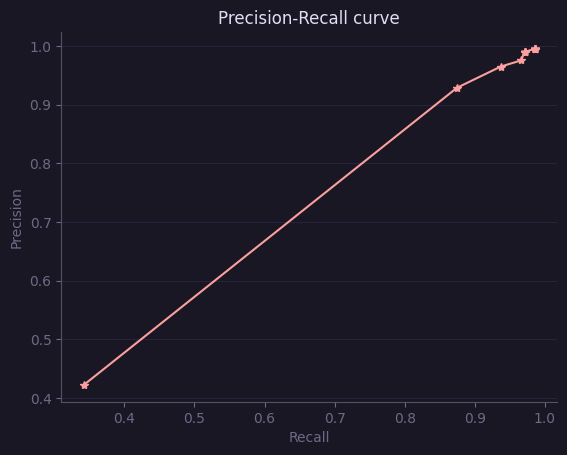

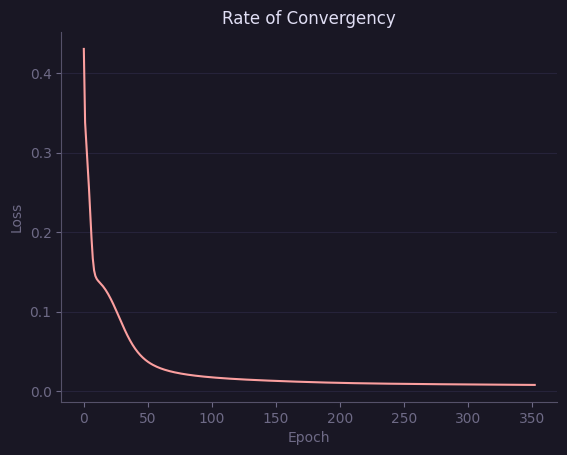

In [240]:



layers=[2,3,4,2]
print(len(layers))

max_steps=10000
#key=2
lr=0.28
k_clases=2
samples=200
labels=jnp.array([0,1])
stop=0.0001
mlp=MultilayerPerceptron(layers,lr,labels,k_clases,samples,x,y,y_hot,stop,max_steps)
loss,recall_list,precision_list,loss_list=mlp.modelo(mlp.weights,max_steps,x,y,y_hot,lr,k_clases,samples,clases,stop)
graficar_pr(recall_list,precision_list)
graficar_rc(loss_list)
#modelo(sizes,key,max_steps,x,y,y_hot,learning_rate,k_clases,samples,clases,stop)

In [261]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds
data_dir = '/home/remote_code/Jax_Excercises/tfds'

In [262]:
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

In [263]:
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [264]:
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [265]:
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels_hot = one_hot(train_labels, num_labels)
print(train_images.shape)

(60000, 784)


In [266]:
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels_hot = one_hot(test_labels, num_labels)
train_labels_hot.shape

(60000, 10)

In [256]:
train_images=jnp.transpose(train_images)/255
print(train_images.shape)
train_labels=jnp.transpose(train_labels)
train_labels_hot=jnp.transpose(train_labels_hot)
test_images=jnp.transpose(test_images)
test_labels=jnp.transpose(test_labels)
test_labels_hot=jnp.transpose(test_labels_hot)


(784, 60000)


60000
In the epoch     0 the loss is 0.47428 and the accuracy is 0.11567
In the epoch     0 the precission is 0.10312 and the recall is 0.10101
In the epoch    10 the loss is 0.43120 and the accuracy is 0.13165
In the epoch    20 the loss is 0.39707 and the accuracy is 0.14783
In the epoch    30 the loss is 0.36936 and the accuracy is 0.16505
In the epoch    40 the loss is 0.34666 and the accuracy is 0.18240
In the epoch    50 the loss is 0.32787 and the accuracy is 0.20008
In the epoch    60 the loss is 0.31212 and the accuracy is 0.21633
In the epoch    70 the loss is 0.29869 and the accuracy is 0.23233
In the epoch    80 the loss is 0.28706 and the accuracy is 0.24522
In the epoch    90 the loss is 0.27686 and the accuracy is 0.25750
In the epoch   100 the loss is 0.26781 and the accuracy is 0.26918
In the epoch   110 the loss is 0.25969 and the accuracy is 0.28217
In the epoch   120 the loss is 0.25235 and the accuracy is 0.29380
In the epoch   130 the loss is 0.24565 and the accur

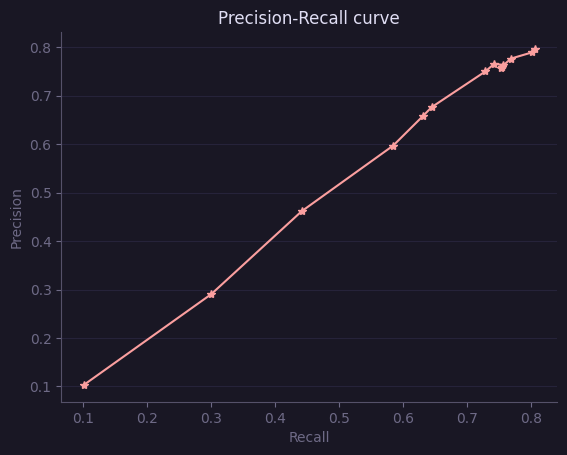

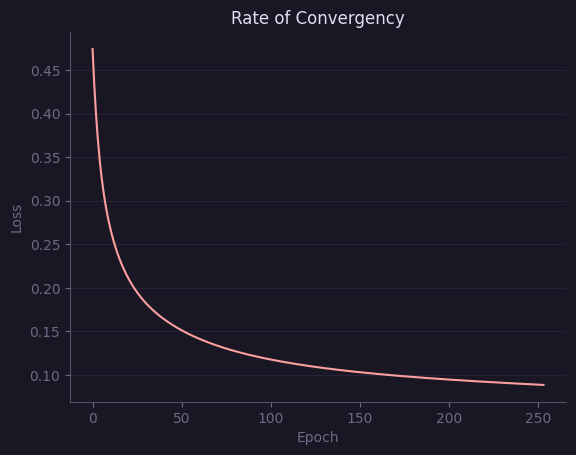

In [249]:
layers=[784,15,10]
samples=train_images.shape[1]
#samples=60000
print(samples)
clases=jnp.array([0,1,2,3,4,5,6,7,8,9])
lr=0.5
max_step=10000
k_classes=10
inpt_size=784

stop=0.00001
max_steps=10000
#weights,max_steps,x,y,y_hot,learning_rate,k_clases,samples,labels,stop
#self,layers,lr,labels,k_clases,samples,x,y,y_hot,stop,max_steps
mlp=MultilayerPerceptron(layers,lr,clases,k_classes,samples,train_images,train_labels,train_labels_hot,stop,max_steps)
loss,recall_list,precision_list,loss_list=mlp.modelo(mlp.weights,max_steps,train_images,train_labels,train_labels_hot,lr,k_classes,samples,clases,stop)
graficar_pr(recall_list,precision_list)
graficar_rc(loss_list)

Ejercicio 2.
========================
Utilizar un MLP como kernel convolucional

In [327]:
#first we reduce the dataset size 
import tensorflow as tf
from tensorflow import keras
n_test=2
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images=train_images[:n_test]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255
train_images=np.transpose(train_images)
train_images = np.expand_dims(train_images,axis=3)

#convert to jax
train_images=jnp.asarray(train_images)
test_images=jnp.asarray(test_images)
print(train_images.shape)



(28, 28, 2, 1)


In [328]:
layers=[4,4,4]
samples=train_images.shape[1]
#samples=60000
print(samples)
clases=jnp.array([0,1,2,3,4,5,6,7,8,9])
lr=0.5
max_step=10000
k_classes=10
inpt_size=784

stop=0.00001
max_steps=10000

mlp=MultilayerPerceptron(layers,lr,clases,k_classes,samples,train_images,train_labels,train_labels_hot,stop,max_steps)


28


In [333]:
#Vamos a barrer la imagen completa con filtros de 2x2 y meter cada cuadrito en un MLP
def barrer(image):
        out = jnp.zeros((14, 14, 4))
        for j in range(0, 28, 2): 
                
                for k in range(0, 28, 2):
                # Process a squared 2x2 region of the image 
                        patch=[train_images[j, k, 0], 
                                train_images[j, k + 1, 0],
                                train_images[j + 1, k, 0],
                                train_images[j + 1, k + 1, 0]]
                        patch=jnp.array(patch)
                        result=mlp.forward(mlp.weights,patch)
                        #result=mlp.prediction(soft)
                        #print(result.shape)
                
                # Assign output values to different channels of the output pixel (j/2, k/2)
                for c in range(4):
                        out.at[j //2, k//2 , c].set(result[c])
        return out
        

In [335]:
preprocessed_images = []
print(train_images.shape)

#we need to iterate on all images of the dataset 
for  img in enumerate(train_images): 
    print(img)
    #we append all images with the pixels rotated.
    preprocessed_images.append(barrer(img)) 
preprocessed_images = np.asarray(preprocessed_images) #and finally we convert to array
print(preprocessed_images)



(28, 28, 2, 1)
(0, DeviceArray([[[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[0.],
              [0.]],

             [[

AssertionError: length mismatch: [1, 0]

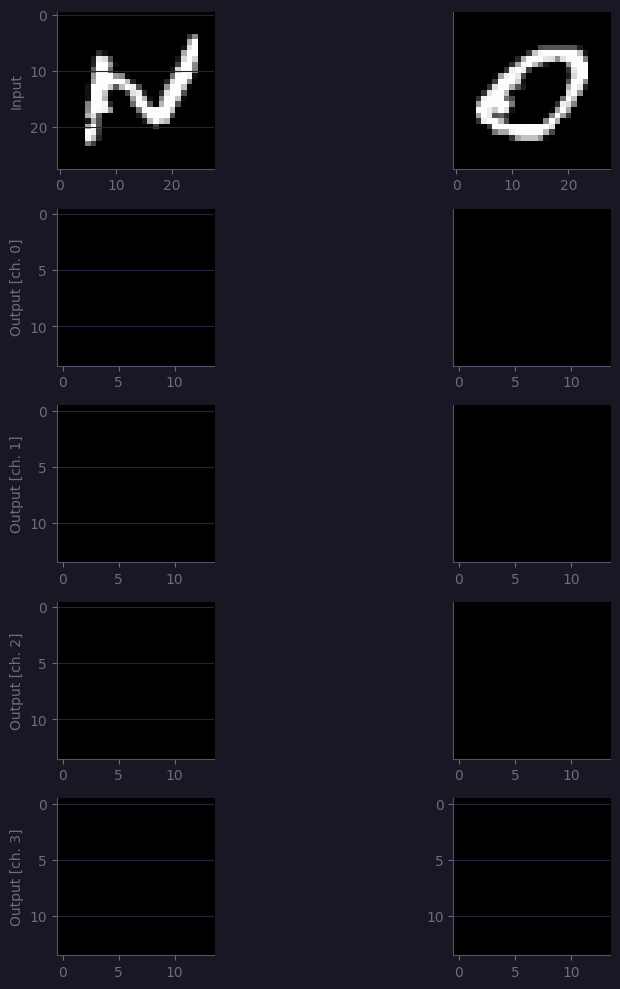

In [332]:
n_samples = 2
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[:, :, k,:], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(preprocessed_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()